In [838]:
import os
import io
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import lightning as L
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np

PATH_DATASETS = os.environ.get("\data", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)
LOG_DIR = os.environ.get("\CNN_log", ".")

In [754]:
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.13,), (0.31,)),
            ]
        )

train_set = datasets.MNIST(root=PATH_DATASETS, download=True, train=True, transform=transform)
test_set = datasets.MNIST(root=PATH_DATASETS, download=True, train=False, transform=transform)

train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

train_set, valid_set = random_split(train_set, [train_set_size, valid_set_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, persistent_workers=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, persistent_workers=True)


In [755]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(24*24*32, 128),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

In [756]:
class CNNCLassifier(L.LightningModule):
    def __init__(self, CNN):
        super().__init__()
        self.CNN = CNN
        self.counter = 0

    def gen_plot(imgs, test_softmax, test_preds, *args):
        fig = plt.figure()
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.tight_layout()
            plt.imshow(imgs.cpu()[i][0], cmap='gray', interpolation='none')
            conf = test_softmax[0][i].item()
            plt.title(f"Prediction: {test_preds[i]} \n Confidence: {round(conf, 3)}")
            plt.xticks([])
            plt.yticks([])
            plt.close()
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg')
        buf.seek(0)
        return buf

    def training_step(self, batch):
        imgs, labels = batch
        preds = self.CNN(imgs)
        train_loss = F.cross_entropy(preds, labels)
        train_preds = preds.argmax(dim=1).float()
        train_acc = sum(train_preds == labels) / len(labels)
        self.log_dict({"train_loss" : train_loss, "train_acc" : train_acc},  prog_bar=True)
        return train_loss

    def validation_step(self, batch):
        imgs, labels = batch
        preds = self.CNN(imgs)
        val_loss = F.cross_entropy(preds, labels)
        val_preds = preds.argmax(dim=1)
        val_acc = sum(val_preds == labels) / len(labels)
        self.log_dict({"val_loss" : val_loss, "val_acc" : val_acc}, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.CNN(imgs)
        test_loss = F.cross_entropy(preds, labels)
        test_preds = preds.argmax(dim=1)
        test_softmax = F.softmax(preds, dim=1)
        test_softmax = torch.max(test_softmax, 1)
        test_acc = sum(test_preds == labels) / len(labels)
        self.log_dict({"test_loss" : test_loss, "test_acc" : test_acc}, prog_bar=True)
        if self.counter < 9:
            for i in range(len(test_preds)):
                if self.counter > 8:
                    break
                elif test_preds[i] == 4:
                    plt.subplot(3,3,self.counter+1)
                    plt.tight_layout()
                    plt.imshow(imgs.cpu()[i][0], cmap='gray', interpolation='none')
                    conf = test_softmax[0][i].item()
                    plt.title(
                        f"Prediction: {test_preds[i]} \n Label: {labels[i]} \n Confidence: {round(conf, 3)}")
                    plt.xticks([])
                    plt.yticks([])
                    self.counter += 1
            buf = io.BytesIO()
            plt.savefig(buf, format='jpeg')
            buf.seek(0)
            image = PIL.Image.open(buf)
            image = ToTensor()(image)
            self.logger.experiment.add_image("Digit predictions", image, dataformats='CHW')
        else:
            plt.close()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [757]:
model = CNNCLassifier(CNN())
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=1,
    default_root_dir="CNN_LOGS/",
)
trainer.fit(model, train_loader, valid_loader)
trainer.test(model, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | CNN  | CNN  | 2.4 M 
------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.462     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 750/750 [00:11<00:00, 64.00it/s, v_num=0, train_loss=0.0105, train_acc=1.000, val_loss=0.081, val_acc=0.977]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 144.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9793999791145325
        test_loss           0.06752050668001175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06752050668001175, 'test_acc': 0.9793999791145325}]

In [1024]:

%load_ext tensorboard
%tensorboard --logdir CNN_LOGS/lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [965]:
#Loads dataset with only 4
cls = 4
four_set = datasets.MNIST(root=PATH_DATASETS, download=True, train=False, transform=transform)
#four_set = list(filter(lambda i: i[1] == cls, four_set))
#four_loader = DataLoader(four_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, persistent_workers=True)

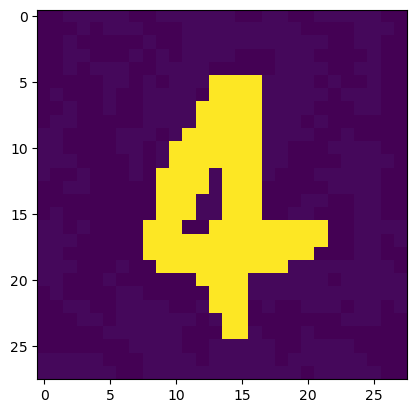

tensor([[-259.27,   95.48, -287.27, -104.26,  666.73, -246.83,  225.28,  199.68,
          -44.11,  148.01]], grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([1.], grad_fn=<MaxBackward0>),
indices=tensor([4]))


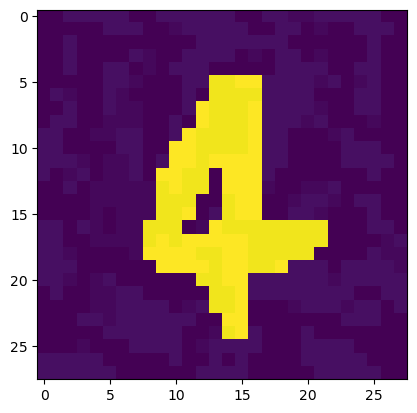

tensor([[-0.45,  0.25, -0.65, -0.54,  1.66, -0.45,  0.60,  0.43, -0.37,  0.42]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.36], grad_fn=<MaxBackward0>),
indices=tensor([4]))


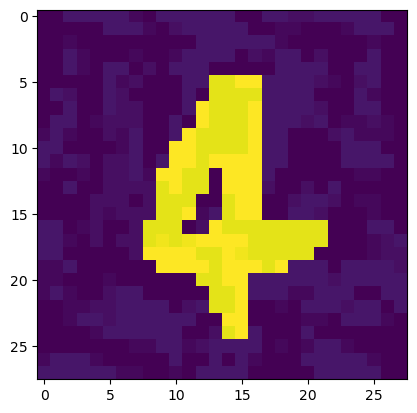

tensor([[-0.46,  0.17, -0.71, -0.54,  1.58, -0.36,  0.54,  0.41, -0.37,  0.55]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.35], grad_fn=<MaxBackward0>),
indices=tensor([4]))


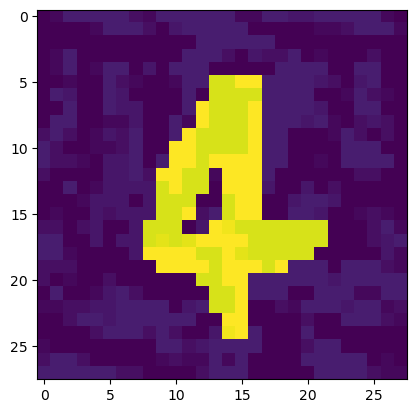

tensor([[-0.47,  0.10, -0.74, -0.53,  1.49, -0.26,  0.48,  0.38, -0.36,  0.66]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.32], grad_fn=<MaxBackward0>),
indices=tensor([4]))


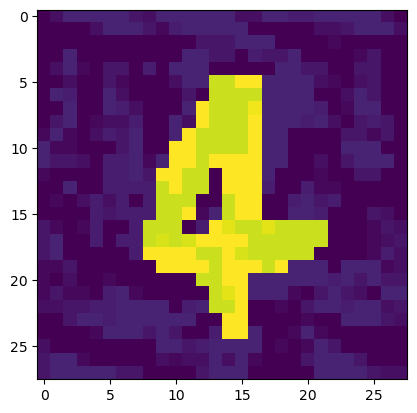

tensor([[-0.47,  0.03, -0.76, -0.53,  1.40, -0.17,  0.40,  0.36, -0.35,  0.77]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.30], grad_fn=<MaxBackward0>),
indices=tensor([4]))


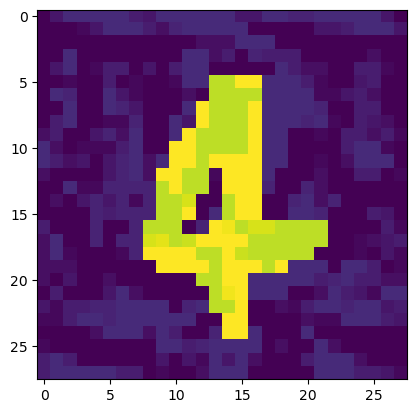

tensor([[-0.49, -0.03, -0.78, -0.53,  1.32, -0.09,  0.32,  0.35, -0.33,  0.88]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.28], grad_fn=<MaxBackward0>),
indices=tensor([4]))


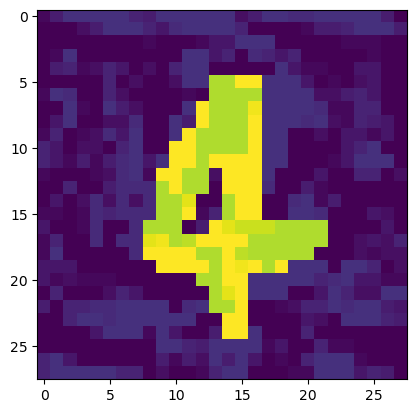

tensor([[-0.49, -0.10, -0.80, -0.55,  1.25, -0.01,  0.26,  0.33, -0.31,  1.00]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.27], grad_fn=<MaxBackward0>),
indices=tensor([4]))


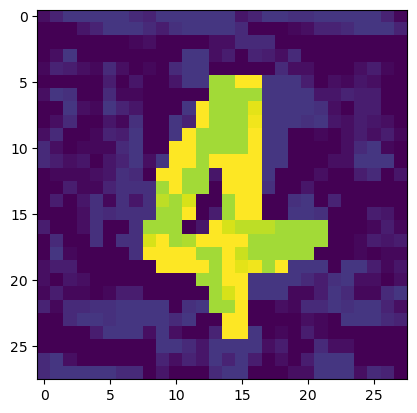

tensor([[-0.48, -0.16, -0.80, -0.55,  1.18,  0.06,  0.19,  0.30, -0.31,  1.11]],
       grad_fn=<AddmmBackward0>)
tensor([4])
torch.return_types.max(
values=tensor([0.25], grad_fn=<MaxBackward0>),
indices=tensor([4]))


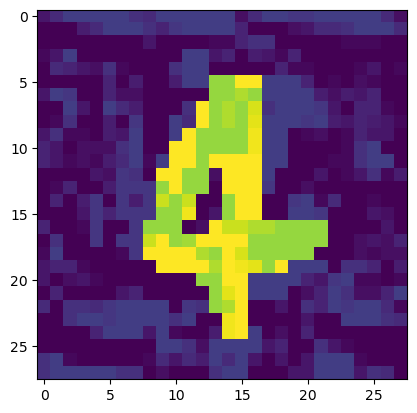

tensor([[-0.48, -0.22, -0.83, -0.55,  1.12,  0.13,  0.13,  0.28, -0.31,  1.22]],
       grad_fn=<AddmmBackward0>)
tensor([9])
torch.return_types.max(
values=tensor([0.26], grad_fn=<MaxBackward0>),
indices=tensor([9]))


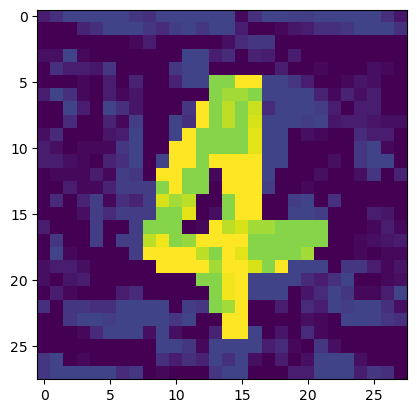

tensor([[-0.49, -0.26, -0.85, -0.55,  1.08,  0.18,  0.09,  0.24, -0.31,  1.33]],
       grad_fn=<AddmmBackward0>)
tensor([9])
torch.return_types.max(
values=tensor([0.28], grad_fn=<MaxBackward0>),
indices=tensor([9]))


In [1020]:
index_of_cls = four_set.targets == cls
rand_index = np.random.randint(0, index_of_cls.sum())
x_image = four_set.data[index_of_cls][rand_index].type(torch.float32).unsqueeze(0).unsqueeze(1)
x_image.requires_grad = True
label_adv = torch.tensor([9], dtype=torch.long)
#Show one four and predict class
#images, labels = next(iter(four_loader))

#four_set.requires_grad = True
#pred = model.CNN(four_set)
lr=0.2
n_steps=10


org_img = image_norm.clone().detach()
probs_per_step = []


#optimizer = torch.optim.SGD([x_image.requires_grad_()], lr=lr)

for _ in range(n_steps):
    optimizer.zero_grad()
    pred = model.CNN(x_image)
    loss = F.cross_entropy(pred, label_adv)
    loss.backward()
    gradient = x_image.grad
    x_adv = x_image - lr * gradient.sign() / n_steps
    x_adv = torch.clamp(x_adv, 0, 1)
    x_image = x_adv.detach().requires_grad_(True)
    plt.imshow(x_image[0][0].detach().numpy())
    plt.show()
    print(pred)
    test_pred = pred.argmax(dim=1)
    print(test_pred)
    test_softmax = F.softmax(pred, dim=1)
    test_softmax = torch.max(test_softmax, 1)
    print(test_softmax)





In [1014]:

pred = model.CNN(image_norm)

#Calculate loss
loss = F.cross_entropy(pred, label_adv)
loss.backward()
deriv = image_norm.grad
image_adv = x - torch.sign(deriv) * lr / n_steps
image_adv = torch.clamp(image_adv, min=0, max=1)

image_norm = torch.add(image_norm, image_adv)
plt.imshow(image_adv[0][0])
plt.show()

plt.imshow(image_norm[0][0].detach().numpy())
plt.show()

pred = model.CNN(image_norm)
print(pred)
test_pred = pred.argmax(dim=1)
print(test_pred)
test_softmax = F.softmax(pred, dim=1)
test_softmax = torch.max(test_softmax, 1)
print(test_softmax)

/var/folders/s9/bg_8ddhj38x2g3svq29mlmcc0000gn/T/ipykernel_31551/4081521674.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/build/aten/src/ATen/core/TensorBody.h:494.)
  deriv = image_norm.grad


TypeError: sign(): argument 'input' (position 1) must be Tensor, not NoneType